# Importing Libraries, Setting Helper Fucnctions and Reading in Data

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import pyplot

import math
import os
import statistics

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

# an initial clean-up function
def clean_up(df,ds='rawdata1'):
    df["YEAR"] = df["YEAR"].astype('str')
    df["MONTH"] = df["MONTH"].astype('str')
    df["DATE"] = df["MONTH"] + '-' + df["YEAR"]
    df["DATE"] =  pd.to_datetime(df["DATE"], format="%m-%Y")
    df['half year'] = np.where(df['DATE'].dt.month.le(6), 'H1', 'H2')
    col = df['half year'] + '-' + df["YEAR"]
    
    if ds == 'rawdata1':
        df["CATEGORY_ID"] = df["CATEGORY_ID"].astype('str')
        df.insert(1,'HALF YEAR',col)
    else:
        df.insert(0,'HALF YEAR',col)
        
    df = df.drop(['YEAR','MONTH','half year'], axis=1)
    df = df.set_index('DATE')
    
    df["STORE"] = df["STORE"].astype('int')
    df["DAYPART"] = df["DAYPART"].astype('str')
    
    return df


# a function to produce pivots that help with store-level daypart view
def daypart_view(df,st1,st2,dp):
    df = rawdata2[(rawdata2['STORE']==st1) | (rawdata2['STORE']==st2)]
    df = df[df['DAYPART']==dp]

    df = pd.pivot_table(df, values='CUSTOMER_COUNT', index=['STORE'],
                           columns=['HALF YEAR'], aggfunc="sum")
    df.columns.name = None

    column_to_move = df.pop("H1-2019")
    df.insert(2, "H1-2019", column_to_move)
    
    return df


# Settings
pd.set_option('display.max_columns', 50)
os.chdir('C:/Users/darre/Documents/Restaurant-Pricing')

In [2]:
rawdata1 = pd.read_csv('RAWDATA1.csv')
rawdata2 = pd.read_csv('RAWDATA2.csv')
rawdata3 = pd.read_csv('RAWDATA3.csv')
rawdata4 = pd.read_csv('RAWDATA4.csv')

# Clean-Up on Data

## RawDate1

In [3]:
rawdata1.head(3)

,YEAR,MONTH,STORE,DAYPART,CATEGORY_ID,REVENUE_NET,QTY
0,2018,1,1,B,10,11700,2050
1,2018,1,1,D,10,3700,570
2,2018,1,1,L,10,7700,1270


In [4]:
rawdata1 = clean_up(rawdata1,ds='rawdata1')
rawdata1.head(3)

,HALF YEAR,STORE,DAYPART,CATEGORY_ID,REVENUE_NET,QTY
DATE,,,,,,
2018-01-01,H1-2018,1,B,10,11700,2050
2018-01-01,H1-2018,1,D,10,3700,570
2018-01-01,H1-2018,1,L,10,7700,1270


## RawDate2

In [5]:
rawdata2.head(3)

,STORE,DAYPART,YEAR,MONTH,CUSTOMER_COUNT
0,1,B,2018,1,3312
1,1,B,2018,2,3366
2,1,B,2018,3,4116


In [6]:
rawdata2 = clean_up(rawdata2,ds='rawdata2')
rawdata2.head(3)

,HALF YEAR,STORE,DAYPART,CUSTOMER_COUNT
DATE,,,,
2018-01-01,H1-2018,1,B,3312
2018-02-01,H1-2018,1,B,3366
2018-03-01,H1-2018,1,B,4116


## RawDate3

In [7]:
rawdata3 = rawdata3.set_index('STORE')
rawdata3.head(3)

,CITY,STATE,NAME,AREA,REGIONAL_DIRECTOR,REGION
STORE,,,,,,
1,RIO GRANDE,OH,RIO GRANDE,1,"GREEN, JOE","GRANDE, OH"
2,CHILLICOTHE,OH,CHILLICOTHE,26,"YELLOW, JAMES","CHILLICOTHE, OH"
3,COLUMBUS,OH,ROUTE 161,7,"YELLOW, JAMES","COLUMBUS, OH"


## RawDate4

In [8]:
rawdata4 = rawdata4.set_index('CATEGORY_ID')
rawdata4.head(4)

,CATEGORY_DESC,COMMENTS
CATEGORY_ID,,
10,BREAKFAST,Breakfast items
15,SENIORS MEALS,Seniors Meals
20,DINNER,Dinner items
25,DINNER ALA,Dinner a-la carte items


# Preliminary Analysis

## System Wide View

In [9]:
rawdata1_A = rawdata1.groupby(['HALF YEAR'])['REVENUE_NET'].sum().to_frame().T

In [10]:
rawdata1_A

HALF YEAR,H1-2018,H1-2019,H2-2018
REVENUE_NET,8372700,8491200,8844600


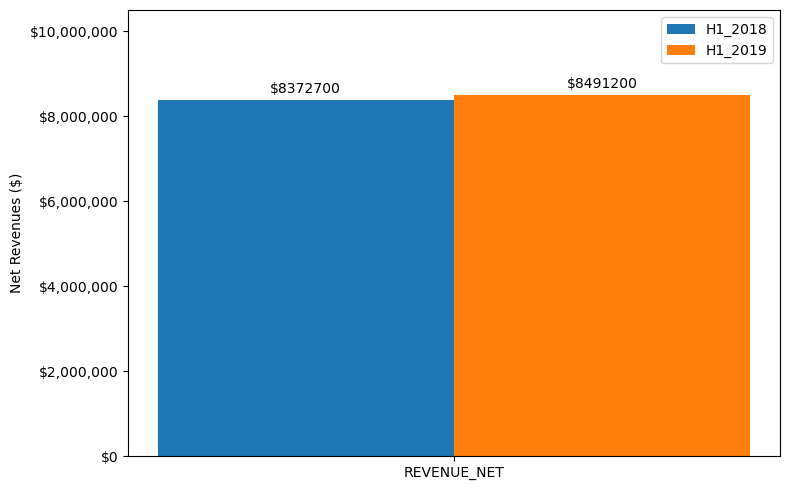

In [11]:
labels = rawdata1_A.index # Days

H1_2018 = rawdata1_A['H1-2018']
H1_2019 = rawdata1_A['H1-2019']

x = np.arange(len(labels)) # location of x ticks
width = 0.4 # width of bars

fig, ax = plt.subplots(figsize=(8,5))
p1 = ax.bar(x - width/2, H1_2018, width, label = "H1_2018")
p2 = ax.bar(x + width/2, H1_2019, width, label = "H1_2019")

#labels
ax.set_ylabel('Net Revenues ($)')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_ylim(0,10500000)

ax.bar_label(p1, padding=3, fmt="$%.0f")
ax.bar_label(p2, padding=3, fmt="$%.0f")

ax.yaxis.set_major_formatter("${x:,.0f}")

ax.legend()

fig.tight_layout()
plt.show()

In [12]:
rawdata2_A = rawdata2.groupby(['HALF YEAR'])['CUSTOMER_COUNT'].sum().to_frame().T

In [13]:
rawdata2_A

HALF YEAR,H1-2018,H1-2019,H2-2018
CUSTOMER_COUNT,1177789,1136657,1241249


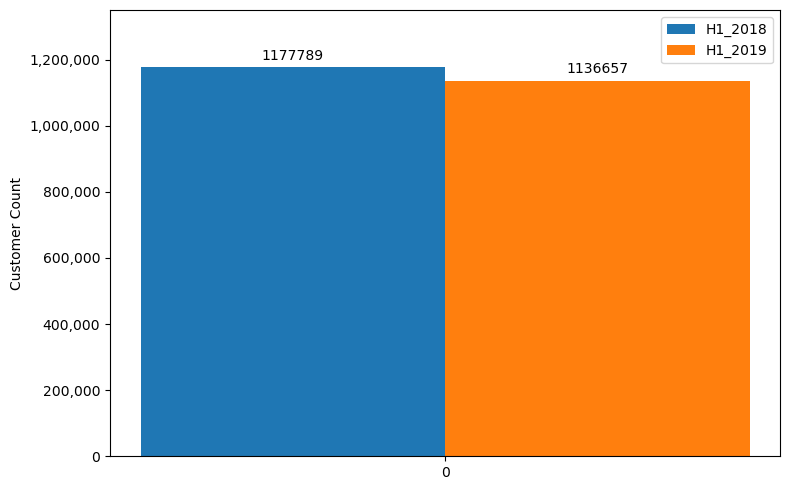

In [14]:
labels = rawdata2_A.index # Days

H1_2018 = rawdata2_A['H1-2018']
H1_2019 = rawdata2_A['H1-2019']

x = np.arange(len(labels)) # location of x ticks
width = 0.4 # width of bars

fig, ax = plt.subplots(figsize=(8,5))
p1 = ax.bar(x - width/2, H1_2018, width, label = "H1_2018")
p2 = ax.bar(x + width/2, H1_2019, width, label = "H1_2019")

#labels
ax.set_ylabel('Customer Count')
ax.set_xticks(x)
ax.set_ylim(0,1350000)

ax.bar_label(p1, padding=3, fmt="%.0f")
ax.bar_label(p2, padding=3, fmt="%.0f")

ax.yaxis.set_major_formatter("{x:,.0f}")

ax.legend()

fig.tight_layout()
plt.show()

## Daypart Level View

In [15]:
rawdata2_B = pd.pivot_table(rawdata2, values='CUSTOMER_COUNT', index=['DAYPART'],
                       columns=['HALF YEAR'], aggfunc="sum")
rawdata2_B.columns.name = None

column_to_move = rawdata2_B.pop("H1-2019")
rawdata2_B.insert(2, "H1-2019", column_to_move)

In [16]:
rawdata2_B

,H1-2018,H2-2018,H1-2019
DAYPART,,,
B,381138,400542,351877
D,342721,363090,341040
L,453930,477617,443740


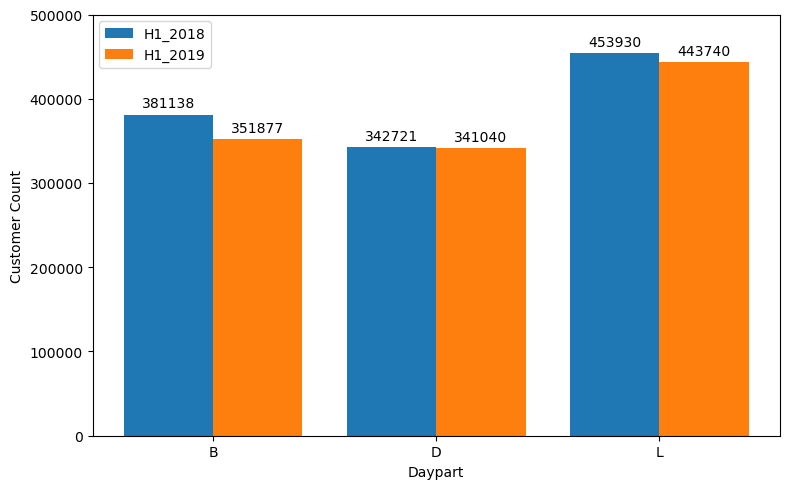

In [17]:
labels = rawdata2_B.index # Days

H1_2018 = rawdata2_B['H1-2018']
H2_2018 = rawdata2_B['H2-2018']
H1_2019 = rawdata2_B['H1-2019']

x = np.arange(len(labels)) # location of x ticks
width = 0.4 # width of bars

fig, ax = plt.subplots(figsize=(8,5))
p1 = ax.bar(x - width/2, H1_2018, width, label = "H1_2018")
p2 = ax.bar(x + width/2, H1_2019, width, label = "H1_2019")

#labels
ax.set_ylabel('Customer Count')
ax.set_xlabel('Daypart')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_ylim(0,500000)
ax.legend()

ax.bar_label(p1, padding=3, fmt="%.0f")
ax.bar_label(p2, padding=3, fmt="%.0f")

fig.tight_layout()
plt.show()

## Store Level View

In [18]:
rawdata2_C = pd.pivot_table(rawdata2, values='CUSTOMER_COUNT', index=['STORE'],
                       columns=['HALF YEAR'], aggfunc="sum")
rawdata2_C.columns.name = None

column_to_move = rawdata2_C.pop("H1-2019")
rawdata2_C.insert(2, "H1-2019", column_to_move)

In [19]:
rawdata2_C.head(10)

,H1-2018,H2-2018,H1-2019
STORE,,,
1,106278,116647,104287
2,142544,157363,146512
3,116876,122008,110326
4,62613,66529,63869
5,139471,139406,121467
6,126592,131135,120917
7,172346,185004,177573
8,91438,98029,88896
9,85228,86460,82571


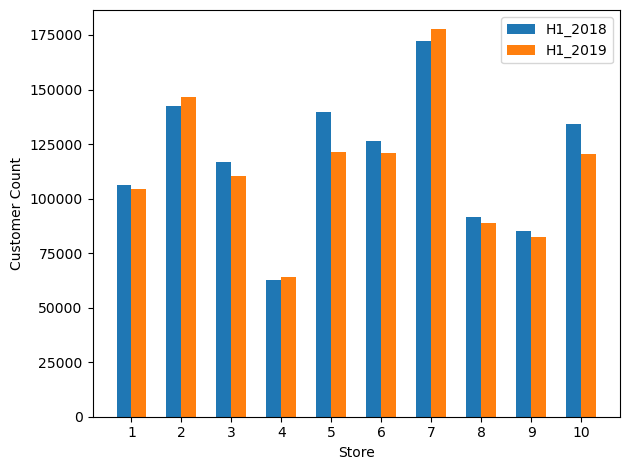

In [20]:
labels = rawdata2_C.index # Days

H1_2018 = rawdata2_C['H1-2018']
H1_2019 = rawdata2_C['H1-2019']

x = np.arange(len(labels)) # location of x ticks
width = 0.3 # width of bars

fig, ax = plt.subplots()
p1 = ax.bar(x - width/2, H1_2018, width, label = "H1_2018")
p2 = ax.bar(x + width/2, H1_2019, width, label = "H1_2019")

#labels
ax.set_ylabel('Customer Count')
ax.set_xlabel('Store')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

fig.tight_layout()
plt.show()

## Stores 5 and 10 By Daypart

In [21]:
view_br = daypart_view(rawdata2,5,10,'B')
view_lnch = daypart_view(rawdata2,5,10,'L')
view_dnr = daypart_view(rawdata2,5,10,'D')

daypart_list = [view_br,view_lnch,view_dnr]

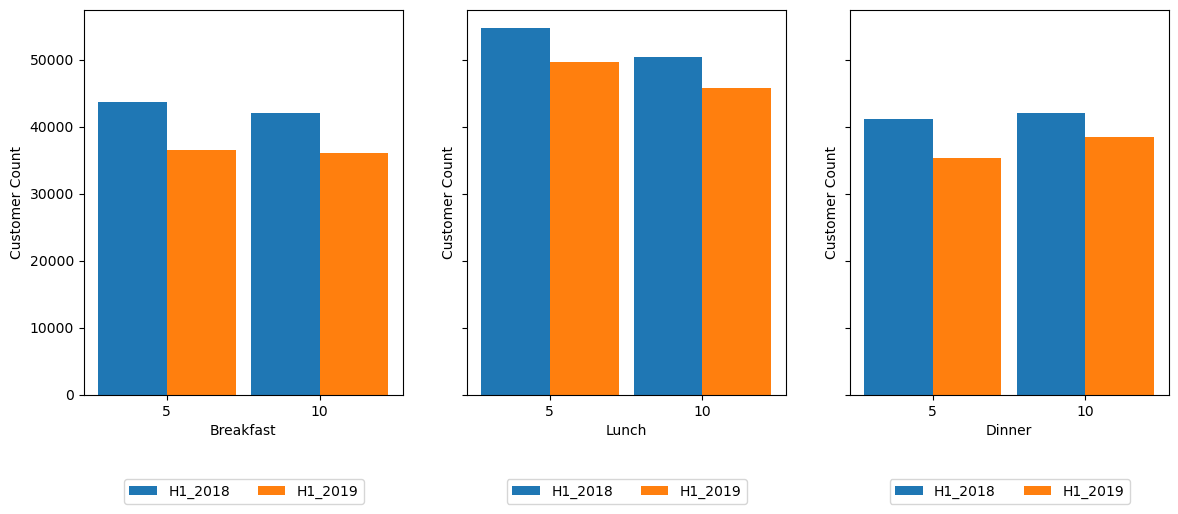

In [22]:
fig, ax = plt.subplots(1,3,figsize=(14,5),sharey=True)

# plot1
df_br = daypart_list[0]
labels = df_br.index # Days
H1_2018 = df_br['H1-2018']
H1_2019 = df_br['H1-2019']
x = np.arange(len(labels)) # location of x ticks
width = 0.45 # width of bars
p1 = ax[0].bar(x - width/2, H1_2018, width, label = "H1_2018")
p2 = ax[0].bar(x + width/2, H1_2019, width, label = "H1_2019")
#labels
ax[0].set_ylabel('Customer Count')
ax[0].set_xlabel('Breakfast')
ax[0].set_xticks(x)
ax[0].set_xticklabels(labels)
ax[0].legend(bbox_to_anchor=(0.9, -0.2),ncol=2)

# plot2
df_lnch = daypart_list[1]
labels = df_lnch.index # Days
H1_2018 = df_lnch['H1-2018']
H1_2019 = df_lnch['H1-2019']
x = np.arange(len(labels)) # location of x ticks
width = 0.45 # width of bars
p1 = ax[1].bar(x - width/2, H1_2018, width, label = "H1_2018")
p2 = ax[1].bar(x + width/2, H1_2019, width, label = "H1_2019")
#labels
ax[1].set_ylabel('Customer Count')
ax[1].set_xlabel('Lunch')
ax[1].set_xticks(x)
ax[1].set_xticklabels(labels)
ax[1].legend(bbox_to_anchor=(0.9, -0.2),ncol=2)

# plot3
df_dnr = daypart_list[2]
labels = df_dnr.index # Days
H1_2018 = df_dnr['H1-2018']
H1_2019 = df_dnr['H1-2019']
x = np.arange(len(labels)) # location of x ticks
width = 0.45 # width of bars
p1 = ax[2].bar(x - width/2, H1_2018, width, label = "H1_2018")
p2 = ax[2].bar(x + width/2, H1_2019, width, label = "H1_2019")
#labels
ax[2].set_ylabel('Customer Count')
ax[2].set_xlabel('Dinner')
ax[2].set_xticks(x)
ax[2].set_xticklabels(labels)
ax[2].legend(bbox_to_anchor=(0.9, -0.2),ncol=2)



# fig.legend(bbox_to_anchor=(0.6, 0), ncol=2)
# fig.tight_layout()
plt.show()

# Forecasting Exercise

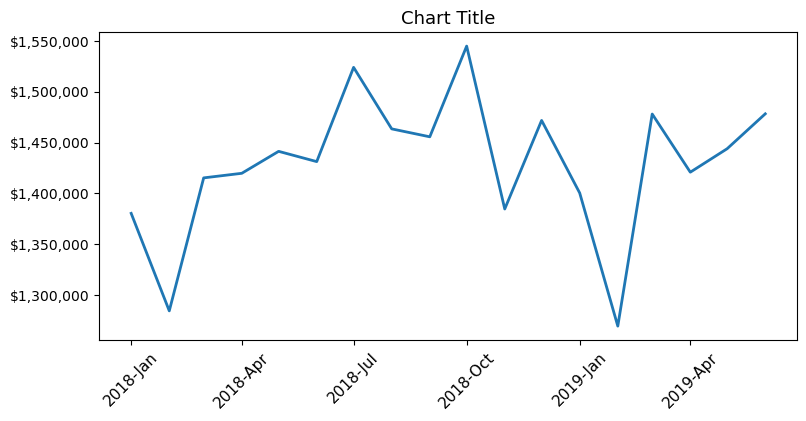

In [23]:
# producing and plotting the intial series
rawdata1_frcst = rawdata1.groupby(['DATE'])['REVENUE_NET'].sum().to_frame()

fig = plt.figure(figsize=(9,4)) # creating the figure object
ax = fig.add_subplot() # creating the chart (axes?) object
ax.set_title('Chart Title',
             fontsize = 13) # title for the chart
ax.plot(rawdata1_frcst.index,rawdata1_frcst['REVENUE_NET'],
        color = 'tab:blue',
        linewidth = 2)
ax.set_xticks(ticks=rawdata1_frcst.index[::3],
              labels = rawdata1_frcst.index[::3].strftime('%Y-%b'),
              rotation=45,
              ha='center',
              fontsize = 11,
              minor=False)
ax.yaxis.set_major_formatter("${x:,.0f}")
plt.show()

In [24]:
# Lung Box test for White Noise
x = rawdata1_frcst.to_numpy()
df = pd.DataFrame(columns=['lb_stat', 'lb_pvalue'])
for i in range(1,17):
    ss = sm.stats.acorr_ljungbox(x, lags=[i], return_df=True)
    df.loc[i,'lb_stat'] = ss.iloc[0,0]
    df.loc[i,'lb_pvalue'] = ss.iloc[0,1]
df

,lb_stat,lb_pvalue
1,0.083959,0.772002
2,0.298484,0.861361
3,1.086487,0.780337
4,5.553595,0.235058
5,5.873238,0.318749
6,7.22881,0.300204
7,9.171865,0.240551
8,9.500623,0.301837
9,9.501373,0.392337
10,9.514684,0.484051


In [25]:
# ADF test for Random Walk

results = adfuller(rawdata1_frcst)

print(f"ADF Statistic: {results[0]}")
print(f"p-value: {results[1]}")
print("Critical Values:")
for key, value in results[4].items():
    print("\t%s: %.3f" % (key, value))

ADF Statistic: -1.4230190801355458
p-value: 0.5711920938966767
Critical Values:
	1%: -4.332
	5%: -3.233
	10%: -2.749


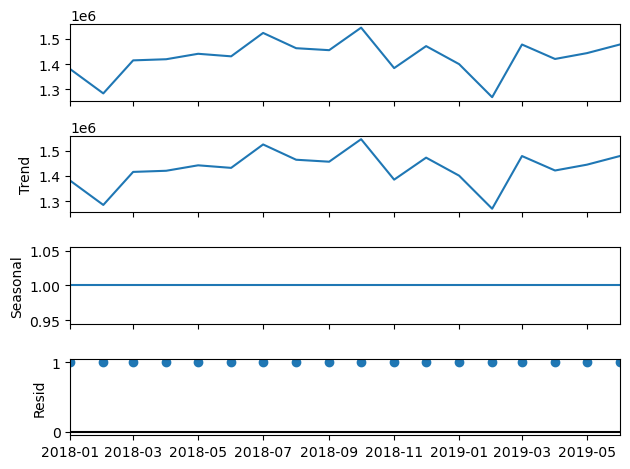

In [26]:
result = seasonal_decompose(rawdata1_frcst, model='multiplicative', period=1)
result.plot()
pyplot.show()

In [27]:
# create s naise forecast
forecast = rawdata1_frcst.copy()
forecast = forecast.iloc[6:12]
forecast = forecast.reset_index()
forecast_index = pd.date_range(start="2019-07",end="2019-12",freq='MS')
forecast.index = forecast_index
forecast = forecast.drop(['DATE'], axis=1)
forecast

,REVENUE_NET
2019-07-01,1524000
2019-08-01,1463500
2019-09-01,1455700
2019-10-01,1544900
2019-11-01,1384700
2019-12-01,1471800


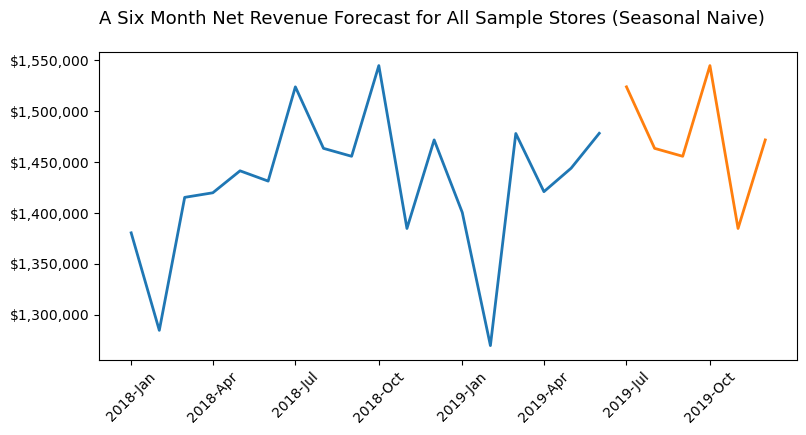

In [28]:
# Plotting Forecast

forecast_index = pd.date_range(start="2018-01",end="2019-12",freq='MS')

fig = plt.figure(figsize=(9,4)) # creating the figure object
ax = fig.add_subplot() # creating the chart (axes?) object
ax.set_title('A Six Month Net Revenue Forecast for All Sample Stores (Seasonal Naive)',
             fontsize = 13, pad = 20, loc = 'left') # title for the chart
ax.plot(rawdata1_frcst.index,rawdata1_frcst['REVENUE_NET'],
        color = 'tab:blue',
        linewidth = 2)
ax.plot(forecast.index,forecast['REVENUE_NET'],
        color = 'tab:orange',
        linewidth = 2)
ax.set_xticks(ticks=forecast_index[::3],
              labels = forecast_index[::3].strftime('%Y-%b'),
              rotation=45,
              ha='center',
              fontsize = 10,
              minor=False)
ax.yaxis.set_major_formatter("${x:,.0f}")
plt.show()

# Investigating Joe Green

In [29]:
rawdata1_B_rev = rawdata1[rawdata1['DAYPART']=='B']
rawdata1_B_rev = pd.pivot_table(rawdata1_B_rev, values=['REVENUE_NET'], index=['DATE'],
                       columns=['STORE'], aggfunc="sum")
rawdata1_B_rev = rawdata1_B_rev.droplevel(0, axis=1) 
rawdata1_B_rev.columns.name = None
rawdata1_B_rev['Total'] = rawdata1_B_rev.sum(axis=1)
rawdata1_B_rev = rawdata1_B_rev[[5,10,'Total']]
rawdata1_B_rev.columns = ['5 - Rev', '10 - Rev','Total - Rev']
rawdata1_B_rev.head(3)

,5 - Rev,10 - Rev,Total - Rev
DATE,,,
2018-01-01,48500,44400,387700
2018-02-01,47900,40000,379000
2018-03-01,51100,47600,431600


In [30]:
rawdata2_D_cuscnt = rawdata2[rawdata2['DAYPART']=='B']
rawdata2_D_cuscnt = pd.pivot_table(rawdata2_D_cuscnt, values=['CUSTOMER_COUNT'], index=['DATE'],
                       columns=['STORE'], aggfunc="sum")
rawdata2_D_cuscnt = rawdata2_D_cuscnt.droplevel(0, axis=1) 
rawdata2_D_cuscnt.columns.name = None
rawdata2_D_cuscnt['Total'] = rawdata2_D_cuscnt.sum(axis=1)
rawdata2_D_cuscnt = rawdata2_D_cuscnt[[5,10,'Total']]
rawdata2_D_cuscnt.columns = ['5 - CustCnt', '10 - CustCnt','Total - CustCnt']
rawdata2_D_cuscnt.head(3)

,5 - CustCnt,10 - CustCnt,Total - CustCnt
DATE,,,
2018-01-01,7247,6863,58844
2018-02-01,6999,6146,56615
2018-03-01,7544,7219,64308


In [31]:
result_df = pd.concat([rawdata1_B_rev, rawdata2_D_cuscnt], axis=1)

In [32]:
result_df['5 - Spend_Per_Customer'] = result_df['5 - Rev'] / result_df['5 - CustCnt']
result_df['10 - Spend_Per_Customer'] = result_df['10 - Rev'] / result_df['10 - CustCnt']
result_df['Total - Spend_Per_Customer'] = result_df['Total - Rev'] / result_df['Total - CustCnt']

In [33]:
result_df.head(3)

,5 - Rev,10 - Rev,Total - Rev,5 - CustCnt,10 - CustCnt,Total - CustCnt,5 - Spend_Per_Customer,10 - Spend_Per_Customer,Total - Spend_Per_Customer
DATE,,,,,,,,,
2018-01-01,48500,44400,387700,7247,6863,58844,6.692424,6.469474,6.588607
2018-02-01,47900,40000,379000,6999,6146,56615,6.843835,6.508298,6.694339
2018-03-01,51100,47600,431600,7544,7219,64308,6.773595,6.593711,6.711451


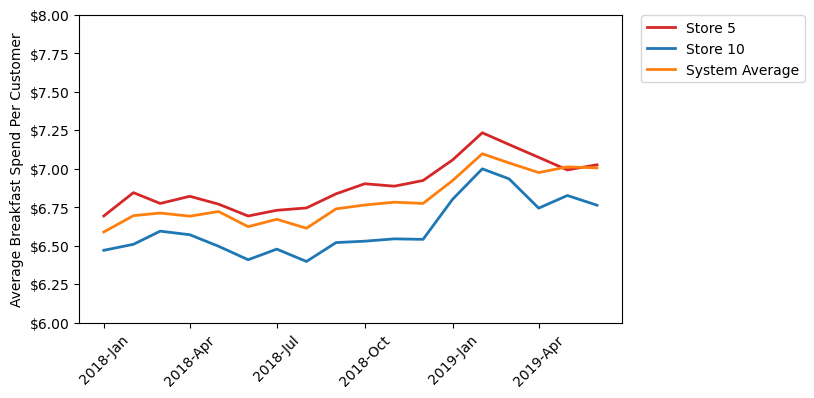

In [34]:
# Plotting Result

fig = plt.figure(figsize=(7,4)) # creating the figure object
ax = fig.add_subplot() # creating the chart (axes?) object
# ax.set_title('Chart Title',
#              fontsize = 13) # title for the chart
ax.plot(result_df.index,result_df['5 - Spend_Per_Customer'],
        color = 'tab:red',
        linewidth = 2,
        label = 'Store 5')
ax.plot(result_df.index,result_df['10 - Spend_Per_Customer'],
        color = 'tab:blue',
        linewidth = 2,
        label = 'Store 10')
ax.plot(result_df.index,result_df['Total - Spend_Per_Customer'],
        color = 'tab:orange',
        linewidth = 2,
        label = 'System Average')
ax.set_xticks(ticks=result_df.index[::3],
              labels = result_df.index[::3].strftime('%Y-%b'),
              rotation=45,
              ha='center',
              fontsize = 10,
              minor=False)
ax.yaxis.set_major_formatter("${x:,.2f}")
ax.set_ylim(6,8)

ax.set_ylabel('Average Breakfast Spend Per Customer')

ax.legend(bbox_to_anchor=(1.35, 1.02))

plt.show()

# Price Elasticity Estimate

In [35]:
# Generating Data Needed to Produce Price Elasticity Model
rawdata1_C = rawdata1.groupby(['DATE','STORE'])[['REVENUE_NET','QTY']].sum().reset_index()
rawdata1_C['Price'] = rawdata1_C['REVENUE_NET'] / rawdata1_C['QTY']

rawdata2_E = rawdata2.groupby(['DATE','STORE'])[['CUSTOMER_COUNT']].sum().reset_index()

column_to_move = rawdata2_E.pop("CUSTOMER_COUNT")
df_ps = rawdata1_C
df_ps.insert(5, "CUSTOMER_COUNT", column_to_move)

In [36]:
df_ps = df_ps[df_ps['STORE']==10]

In [37]:
df_ps.head(3)

,DATE,STORE,REVENUE_NET,QTY,Price,CUSTOMER_COUNT
9,2018-01-01,10,158000,51750,3.053140,22861
19,2018-02-01,10,141300,46030,3.069737,20566
29,2018-03-01,10,159000,51420,3.092182,22973


In [38]:
model = smf.ols(formula='CUSTOMER_COUNT ~ Price', data=df_ps).fit()
print(model.summary())
p = model.params

                            OLS Regression Results                            
Dep. Variable:         CUSTOMER_COUNT   R-squared:                       0.442
Model:                            OLS   Adj. R-squared:                  0.407
Method:                 Least Squares   F-statistic:                     12.68
Date:                Tue, 12 Mar 2024   Prob (F-statistic):            0.00261
Time:                        07:41:26   Log-Likelihood:                -153.18
No. Observations:                  18   AIC:                             310.4
Df Residuals:                      16   BIC:                             312.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   5.777e+04   1.01e+04      5.724      0.0

C:\Users\darre\anaconda3\envs\time_series\Lib\site-packages\scipy\stats\_stats_py.py:1736: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=18
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


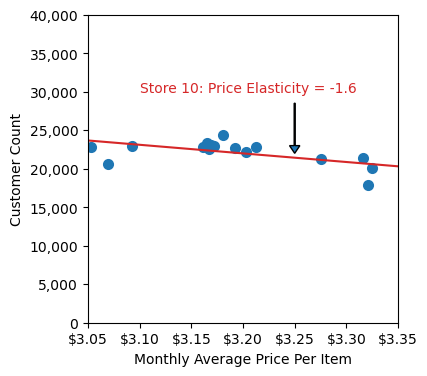

In [39]:
# Plotting Forecast

x = np.arange(0, 5) # a helper for the x axis labels

fig = plt.figure(figsize=(4,4)) # creating the figure object
ax = fig.add_subplot() # creating the chart (axes?) object
# ax.set_title('An Initial Price Elasticity Estimate',
#              fontsize = 15, loc ='left', pad = 25) # title for the chart
ax.text(3.10, 30000, 'Store 10: Price Elasticity = -1.6', fontsize = 10, color = 'tab:red')
ax.scatter(df_ps['Price'],df_ps['CUSTOMER_COUNT'],
        color = 'tab:blue',
        linewidth = 2,
        label = 'LodgingRevenue')
ax.plot(x, p.Intercept + p.Price*x, color = 'tab:red')

ax.yaxis.set_major_formatter("{x:,.0f}")
ax.xaxis.set_major_formatter("${x:,.2f}")
ax.set_ylim(0,40000)
ax.set_xlim(3.05,3.35)
ax.arrow(3.25,28500, 0, -6500, length_includes_head=True,
          head_width=0.01, head_length=1000)
ax.set_ylabel('Customer Count')
ax.set_xlabel('Monthly Average Price Per Item')


plt.show()

# Analysis re Priority Categoriers

In [40]:
rawdata1

,HALF YEAR,STORE,DAYPART,CATEGORY_ID,REVENUE_NET,QTY
DATE,,,,,,
2018-01-01,H1-2018,1,B,10,11700,2050
2018-01-01,H1-2018,1,D,10,3700,570
2018-01-01,H1-2018,1,L,10,7700,1270
2018-02-01,H1-2018,1,B,10,11800,2070
2018-02-01,H1-2018,1,D,10,3700,570
...,...,...,...,...,...,...
2019-05-01,H1-2019,10,D,60,6900,1810
2019-05-01,H1-2019,10,L,60,5500,1710
2019-06-01,H1-2019,10,B,60,1400,780


In [41]:
rawdata1_D = rawdata1[rawdata1['STORE']==5]
rawdata1_D = rawdata1_D[rawdata1_D['CATEGORY_ID']=='45']

In [42]:
# rawdata1_D = rawdata1[rawdata1['CATEGORY_ID']=='15']

In [43]:
rawdata1_D = rawdata1_D.groupby(['HALF YEAR'])['QTY'].sum().reset_index().set_index('HALF YEAR')

In [44]:
rawdata1_D

,QTY
HALF YEAR,
H1-2018,10060
H1-2019,9150
H2-2018,9960


# Price Analysis

In [45]:
def av_price(df,i):
    if i != 0:
        df = df[df['STORE']==i]
    df = df.groupby(['CATEGORY_ID'])[['REVENUE_NET','QTY']].sum().reset_index()
    df['Price'] = df['REVENUE_NET'] / df['QTY']
    qty_sum_store = df['QTY'].sum()
    df['Weight'] = df['QTY'] / qty_sum_store
    df['Weighted Price'] = df['Price'] * df['Weight']
    ave_price = df['Weighted Price'].sum()
    
    return ave_price

In [46]:
av_price_lst = []

for i in range(0,11):
    ave_price = av_price(rawdata1,i)
    av_price_lst.append(ave_price)

av_price_lst

[3.19327720654542,
 3.337991266375546,
 3.198576567367132,
 3.2196180996394292,
 3.202393635106649,
 3.1617679029523025,
 3.1929757859468197,
 3.0819493822951674,
 3.1773762255894984,
 3.239862855543505,
 3.206797744956437]

In [47]:
av_price_lst_np = np.array(av_price_lst[1:12])
perc_75 = np.percentile(av_price_lst_np, 75)
perc_75

3.2164130109686813

In [48]:
stores = ['System Average','Store 1','Store 2','Store 3','Store 4',\
          'Store 5','Store 6','Store 7','Store 8','Store 9','Store 10',]
list_of_tuples = list(zip(stores, av_price_lst))
plot_values = pd.DataFrame(list_of_tuples, columns = ['Store', 'Average Price']).set_index('Store')
plot_values.head(3)

,Average Price
Store,
System Average,3.193277
Store 1,3.337991
Store 2,3.198577


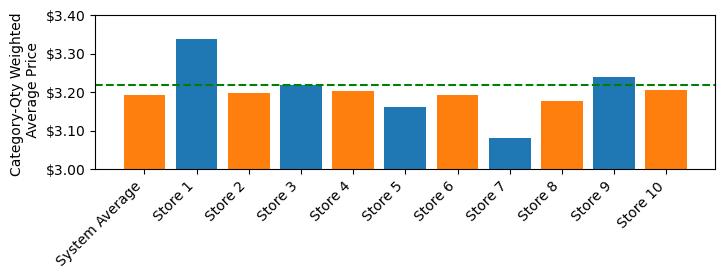

In [49]:
fig = plt.figure(figsize=(8,2)) # creating the figure object
ax = fig.add_subplot() # creating the chart (axes?) object
ax.bar(plot_values.index,
       plot_values['Average Price'],
        color = ['tab:orange','tab:blue'])
ax.set_xticks(
    ticks=plot_values.index,
    labels = plot_values.index,
    rotation=45,
    ha='right',
    fontsize = 10,
    minor=False)
ax.set_ylim(3,3.4)
ax.set_ylabel('Category-Qty Weighted \n Average Price', fontsize = 10) # title for the chart
ax.yaxis.set_major_formatter("${x:,.2f}")
ax.axhline(3.22, linestyle = '--', color = 'green')
plt.show()
